## Notebook for visualising experiment 1 results
### This notebook is for user to visualise the results from experiment 1, with comparison with the ground truth data.


Defining Functions for Plotting: This section defines utility functions used for handling projections in the plots.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import torch
import matplotlib.pyplot as plt
from pyproj import Transformer
from scipy.spatial import KDTree
from torch.utils.data import TensorDataset, DataLoader


def EASE2toWGS84(x, y, return_vals="both", lon_0=0, lat_0=90):
    """
    Converts EASE2 grid coordinates to WGS84 longitude and latitude coordinates.
    """

    valid_return_vals = ['both', 'lon', 'lat']
    assert return_vals in ['both', 'lon', 'lat'], f"return_val: {return_vals} is not in valid set: {valid_return_vals}"
    EASE2 = f"+proj=laea +lon_0={lon_0} +lat_0={lat_0} +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"
    WGS84 = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
    transformer = Transformer.from_crs(EASE2, WGS84)
    lon, lat = transformer.transform(x, y)
    if return_vals == "both":
        return lon, lat
    elif return_vals == "lon":
        return lon
    elif return_vals == "lat":
        return lat


def WGS84toEASE2(lon, lat, return_vals="both", lon_0=0, lat_0=90):
    """
    Converts WGS84 longitude and latitude coordinates to EASE2 grid coordinates.
    """

    valid_return_vals = ['both', 'x', 'y']
    assert return_vals in ['both', 'x', 'y'], f"return_val: {return_vals} is not in valid set: {valid_return_vals}"
    EASE2 = f"+proj=laea +lon_0={lon_0} +lat_0={lat_0} +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"
    WGS84 = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
    transformer = Transformer.from_crs(WGS84, EASE2)
    x, y = transformer.transform(lon, lat)
    if return_vals == 'both':
        return x, y
    elif return_vals == "x":
        return x
    elif return_vals == "y":
        return y


def match(x, y, exact=True, tol=1e-9):
    """
    This function takes two arrays, x and y, and returns an array of indices indicating
    where the elements of x match the elements of y. Can match exactly or within a specified tolerance.
    Require x,y to be arrays.
    """
    # match exactly?
    if exact:
        mask = x[:, None] == y
    # otherwise check where difference is less than tolerance
    # NOTE: only makes sense with floats (use exact=True for int, str)
    else:
        dif = np.abs(x[:, None] - y)
        mask = dif < tol

    row_mask = mask.any(axis=1)
    assert row_mask.all(), \
        f"{(~row_mask).sum()} not found, uniquely : {np.unique(np.array(x)[~row_mask])}"
    return np.argmax(mask, axis=1)


Loading Data: The next cell loads the necessary data for plotting. These datasets are part of the Experiment 1 data used for training the model, available on Google Drive.

In [2]:
gt_df = pd.read_csv('/CryosatMSS-arco-2yr-140821_with_geoid_h.csv')
gt_df.head()

,lon,lat,mss,h
0,-180.0000,88.0,10.4280,11.270550
1,-179.9375,88.0,10.4694,11.275702
2,-179.8750,88.0,10.4806,11.281312
3,-179.8125,88.0,10.4706,11.288182
4,-179.7500,88.0,10.4996,11.295787


In [ ]:
hdf5_file_path = '/along_track_sample_from_mss_ground_ABC.h5'
data_path = "/along_track_sample_from_mss_ground_ABC.h5"
with pd.HDFStore(data_path, mode="r") as store:
    obs_data = store.select('data')
obs_data.head()

,lon,lat,datetime,source,obs,x,y,obs_mean,obs_w_noise,t,date
0,59.944790,82.061122,2020-03-01 13:48:50,C,-0.374696,766835.526399,-443718.474582,-0.694033,-0.300026,18322.575579,2020-03-01
1,59.939555,82.063771,2020-03-01 13:48:50,C,-0.374696,766539.591915,-443640.730012,-0.694033,-0.438093,18322.575579,2020-03-01
2,59.934316,82.066419,2020-03-01 13:48:50,C,-0.374696,766243.660921,-443562.985865,-0.694033,-0.353010,18322.575579,2020-03-01
3,59.929074,82.069068,2020-03-01 13:48:50,C,-0.374696,765947.724567,-443485.235174,-0.694033,-0.424102,18322.575579,2020-03-01
4,59.923829,82.071716,2020-03-01 13:48:50,C,-0.374696,765651.791742,-443407.484810,-0.694033,-0.346922,18322.575579,2020-03-01


In [ ]:

# Load test locations
test_locs = pd.read_csv('/test_locs.csv') # this is the same test_locs.csv used in experiment 2

# Set date to 2020-03-05
date = np.array(np.datetime64('2020-03-05'))
t = date.astype("float")

# Generate 2d array for plotting
delta_x = np.diff(np.sort(test_locs['x'].unique())).min()
delta_y = np.diff(np.sort(test_locs['y'].unique())).min()

x_start = test_locs['x'].min()
x_end = test_locs['x'].max()
x_coords = np.arange(x_start, x_end + delta_x, delta_x)

y_start = test_locs['y'].min()
y_end = test_locs['y'].max()
y_coords = np.arange(y_start, y_end + delta_y, delta_y)

x_grid, y_grid = np.meshgrid(x_coords, y_coords)

# Add columns corresponding to grid indices and date
test_locs['x_idxs'] = match(test_locs['x'].values, x_coords)
test_locs['y_idxs'] = match(test_locs['y'].values, y_coords)

test_locs['date'] = date
test_locs['t'] = t

test_locs.head()


,Unnamed: 0,x,y,lon,lat,is_in_ocean,x_idxs,y_idxs,date,t
0,32,-992500.0,-1952500.0,-26.945263,70.285678,True,401,49,2020-03-05,18326.0
1,56,-987500.0,-1957500.0,-26.769574,70.265646,True,402,48,2020-03-05,18326.0
2,61,-987500.0,-1932500.0,-27.066856,70.468418,True,402,53,2020-03-05,18326.0
3,85,-982500.0,-1962500.0,-26.594239,70.245427,True,403,47,2020-03-05,18326.0
4,86,-982500.0,-1957500.0,-26.652793,70.286093,True,403,48,2020-03-05,18326.0


Plotting Ground Truth: In this section, we visualise the ground truth data.

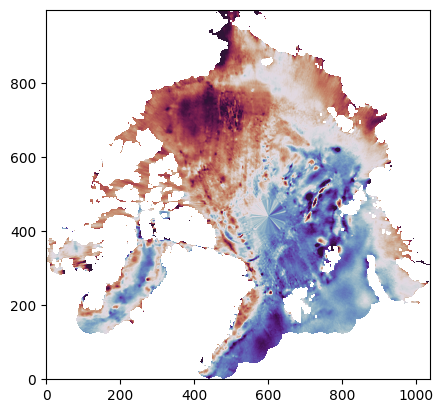

In [5]:
# Plot ground truth
gt_df['z'] = gt_df['mss'] - gt_df['h']
gt_df['z'] = (gt_df['z'] - obs_data['obs_mean'].mean()) # Need to double check
gt_df['x'], gt_df['y'] = WGS84toEASE2(gt_df['lon'], gt_df['lat'])

# Map ground truth coordinates onto a 2d grid
kdt = KDTree(gt_df[['x','y']].values)
_, idx = kdt.query(test_locs[['x', 'y']].values, k=1)

gt2d = np.full(x_grid.shape, np.nan)
gt2d[test_locs['y_idxs'].values, test_locs['x_idxs'].values] = gt_df['z'].values[idx]

plt.imshow(gt2d, vmin=-0.5, vmax=0.5, origin='lower',cmap='twilight_shifted')

De-normalising Predictions: Here, we load the mean and standard deviation for the input and output data to de-normalize the model predictions, converting them back to their original scale.

In [6]:
X = obs_data[['x', 'y']].to_numpy()
Y = obs_data['obs'].to_numpy()

tensor_x = torch.Tensor(X)
tensor_y = torch.Tensor(Y)
X_mean = tensor_x.mean(dim=0)
X_std = tensor_x.std(dim=0)
normalised_tensor_x = (tensor_x - X_mean) / X_std

Y_mean = tensor_y.mean()
Y_std = tensor_y.std()
normalised_tensor_y = (tensor_y - Y_mean) / Y_std
X_train_torch = normalised_tensor_x
y_train_torch = normalised_tensor_y[:,None]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_torch = X_train_torch.to(device)
y_train_torch = y_train_torch.to(device)
test_X = test_locs[['x', 'y']].to_numpy()
test_X = torch.Tensor(test_X)
normalised_test_X = (test_X - X_mean) / X_std
X_test_torch = normalised_test_X.to(device)


Loading Predictions: This step loads the prediction results generated by the model.

In [ ]:
import torch
pred_tensor = torch.load('/final_predictions_exp1.pt')
var_tensor = torch.load('/final_variance_exp1.pt')

Final Plotting: With all data prepared, we now plot the model predictions (prediceted mean and variance) for comparison with the ground truth

In [ ]:
pred1 = pred_tensor
pred_2d_inputs = np.full(x_grid.shape, np.nan)

preds1 = torch.Tensor(pred1)*Y_std + Y_mean

pred_2d_inputs[test_locs['y_idxs'], test_locs['x_idxs']] = preds1.cpu().detach().numpy().squeeze()

plt.imshow(pred_2d_inputs, vmin=-0.5, vmax=0.5, origin='lower',cmap='twilight_shifted')
plt.colorbar()

In [ ]:
pred1 = var_tensor
pred_2d_inputs = np.full(x_grid.shape, np.nan)

preds1 = torch.Tensor(pred1)*(Y_std**2)

pred_2d_inputs[test_locs['y_idxs'], test_locs['x_idxs']] = preds1.cpu().detach().numpy().squeeze()

plt.imshow(pred_2d_inputs, vmin=0, vmax=0.1, origin='lower')
plt.colorbar()